# Multipersistence Analysis on Bus Data

This notebook implements multipersistence topology on bus data using:
- **Node filtration**: Voltage (proxied by TotConnected_ActiveLoad)
- **Edge features**: Branch flow (proxied by capacity)
- **Classifier**: XGBoost
- **Thresholds**: 10-20 thresholds based on quartiles

## Overview
Multipersistence extends traditional persistent homology to multiple parameters simultaneously, allowing us to capture topological features that depend on both node and edge attributes.


### 1. Import Required Modules


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
#import seaborn as sns

# Topological data analysis
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve
import pyflagser

# Machine learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Graph processing
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore')

print("All modules imported successfully!")


All modules imported successfully!


### 2. Load and Parse Bus Data

We'll parse the GML file to extract nodes and edges with their attributes.


In [2]:
def parse_gml_file(filename):
    """
    Parse GML file and extract graph structure with node and edge attributes.
    """
    # Read the GML file
    with open(filename, 'r') as f:
        content = f.read()
    
    # Parse nodes
    nodes = {}
    edges = []
    
    lines = content.split('\n')
    i = 0
    
    # Extract nodes
    while i < len(lines):
        line = lines[i].strip()
        if line == 'node [':
            node_data = {}
            i += 1
            while i < len(lines) and lines[i].strip() != ']':
                line = lines[i].strip()
                if ' ' in line and not line.startswith('[') and not line.startswith(']'):
                    key, value = line.split(' ', 1)
                    # Try to convert to float if possible
                    try:
                        node_data[key] = float(value)
                    except ValueError:
                        node_data[key] = value.strip('"')
                i += 1
            nodes[node_data['id']] = node_data
        elif line == 'edge [':
            edge_data = {}
            i += 1
            while i < len(lines) and lines[i].strip() != ']':
                line = lines[i].strip()
                if ' ' in line and not line.startswith('[') and not line.startswith(']'):
                    key, value = line.split(' ', 1)
                    # Try to convert to float if possible
                    try:
                        edge_data[key] = float(value)
                    except ValueError:
                        edge_data[key] = value.strip('"')
                i += 1
            edges.append(edge_data)
        i += 1
    
    return nodes, edges

# Load bus data
nodes, edges = parse_gml_file('bus37Ex.gml')

print(f"Loaded {len(nodes)} nodes and {len(edges)} edges")
print("\nSample node attributes:")
for node_id, attrs in list(nodes.items())[:3]:
    print(f"Node {node_id}: {attrs}")

print("\nSample edge attributes:")
for i, edge in enumerate(edges[:3]):
    print(f"Edge {i}: {edge}")


Loaded 39 nodes and 38 edges

Sample node attributes:
Node 0.0: {'id': 0.0, 'label': 'sourcebus', 'Device': 'Bus', 'TotConnected_ActiveLoad': 0.0, 'TotConnected_ReactiveLoad': 0.0}
Node 1.0: {'id': 1.0, 'label': '799', 'Device': 'Bus', 'TotConnected_ActiveLoad': 0.0, 'TotConnected_ReactiveLoad': 0.0}
Node 2.0: {'id': 2.0, 'label': '709', 'Device': 'Bus', 'TotConnected_ActiveLoad': 0.0, 'TotConnected_ReactiveLoad': 0.0}

Sample edge attributes:
Edge 0: {'source': 0.0, 'target': 1.0, 'label': 'subxf', 'device': 'Transformer', 'resistance': 0.09215999999999999, 'reactance': 0.7372799999999999, 'phases': 3.0, 'maxcap': 9.413319606352593, 'cap': 7.652101861408848, 'residue': 1.7612177449437443}
Edge 1: {'source': 1.0, 'target': 38.0, 'label': 'jumper', 'device': 'Line', 'resistance': 0.0003333333333333333, 'reactance': 0.0, 'phases': 1.0, 'maxcap': 600.0, 'cap': 0.00017913474065108087, 'residue': 599.9998208652594}
Edge 2: {'source': 2.0, 'target': 3.0, 'label': 'xfm1', 'device': 'Transform

### 3. Construct NetworkX Graph with Attributes

We'll create a NetworkX graph and assign node/edge attributes for multipersistence analysis.


In [3]:
def construct_graph_with_attributes(nodes, edges):
    """
    Construct NetworkX graph with node and edge attributes.
    """
    G = nx.Graph()
    
    # Add nodes with attributes
    for node_id, attrs in nodes.items():
        # Use TotConnected_ActiveLoad as proxy for voltage
        voltage_proxy = attrs.get('TotConnected_ActiveLoad', 0.0)
        G.add_node(node_id, voltage=voltage_proxy, **attrs)
    
    # Add edges with attributes
    for edge in edges:
        source = int(edge['source'])
        target = int(edge['target'])
        # Use 'cap' as proxy for branch flow
        branch_flow_proxy = edge.get('cap', 0.0)
        G.add_edge(source, target, branch_flow=branch_flow_proxy, **edge)
    
    return G

# Construct the graph
G = construct_graph_with_attributes(nodes, edges)

print(f"Graph constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Extract voltage and branch flow values for analysis
voltage_values = [G.nodes[n]['voltage'] for n in G.nodes()]
branch_flow_values = [G.edges[e]['branch_flow'] for e in G.edges()]

print(f"\nVoltage (ActiveLoad) statistics:")
print(f"  Min: {min(voltage_values):.2f}")
print(f"  Max: {max(voltage_values):.2f}")
print(f"  Mean: {np.mean(voltage_values):.2f}")
print(f"  Std: {np.std(voltage_values):.2f}")

print(f"\nBranch Flow (Capacity) statistics:")
print(f"  Min: {min(branch_flow_values):.2f}")
print(f"  Max: {max(branch_flow_values):.2f}")
print(f"  Mean: {np.mean(branch_flow_values):.2f}")
print(f"  Std: {np.std(branch_flow_values):.2f}")


Graph constructed with 39 nodes and 38 edges

Voltage (ActiveLoad) statistics:
  Min: 0.00
  Max: 630.00
  Mean: 63.00
  Std: 102.58

Branch Flow (Capacity) statistics:
  Min: 0.00
  Max: 335.14
  Mean: 49.20
  Std: 68.76


### 4. Generate Synthetic Labels for Classification

Since the bus data doesn't have ground truth labels, we'll create synthetic labels based on network topology characteristics.


In [4]:
def generate_synthetic_labels(graph, n_samples=100):
    """
    Generate synthetic labels based on network characteristics.
    We'll create multiple 'scenarios' by perturbing the original graph.
    """
    graphs = []
    labels = []
    
    # Generate more balanced classes
    np.random.seed(42)
    
    # Class 0: Original graph + slight perturbations (50 samples)
    for i in range(50):
        if i == 0:
            # Original graph
            graphs.append(graph.copy())
        else:
            # Slight perturbations for class 0
            G_perturbed = graph.copy()
            for node in G_perturbed.nodes():
                noise = np.random.normal(0, 0.05 * G_perturbed.nodes[node]['voltage'])  # Smaller noise
                G_perturbed.nodes[node]['voltage'] = max(0, G_perturbed.nodes[node]['voltage'] + noise)
            for edge in G_perturbed.edges():
                noise = np.random.normal(0, 0.05 * G_perturbed.edges[edge]['branch_flow'])  # Smaller noise
                G_perturbed.edges[edge]['branch_flow'] = max(0, G_perturbed.edges[edge]['branch_flow'] + noise)
            graphs.append(G_perturbed)
        labels.append(0)
    
    # Class 1: More significant perturbations (50 samples)
    for i in range(50):
        G_perturbed = graph.copy()
        # Larger perturbations for class 1
        for node in G_perturbed.nodes():
            noise = np.random.normal(0, 0.2 * G_perturbed.nodes[node]['voltage'])  # Larger noise
            G_perturbed.nodes[node]['voltage'] = max(0, G_perturbed.nodes[node]['voltage'] + noise)
        for edge in G_perturbed.edges():
            noise = np.random.normal(0, 0.2 * G_perturbed.edges[edge]['branch_flow'])  # Larger noise
            G_perturbed.edges[edge]['branch_flow'] = max(0, G_perturbed.edges[edge]['branch_flow'] + noise)
        graphs.append(G_perturbed)
        labels.append(1)
    
    return graphs, labels

# Generate synthetic dataset
graphs, labels = generate_synthetic_labels(G, n_samples=100)

print(f"Generated {len(graphs)} graphs with labels: {np.bincount(labels)}")
print(f"Class distribution: {np.bincount(labels) / len(labels)}")


Generated 100 graphs with labels: [50 50]
Class distribution: [0.5 0.5]


### 5. Multipersistence Pipeline Setup

We'll implement multipersistence using voltage for node filtration and branch flow for edge features.


In [5]:
def build_thresholds(values, n_thresholds, use_quantiles=True):
    """
    Build sorted unique threshold array for given values.
    """
    vals = np.asarray(values)
    if vals.size == 0:
        return np.array([0.0])
    if use_quantiles:
        qs = np.linspace(0.0, 1.0, n_thresholds)
        thr = np.quantile(vals, qs)
    else:
        thr = np.linspace(vals.min(), vals.max(), n_thresholds)
    return np.unique(thr)

def compute_betti_numbers_for_active(active_nodes, graph):
    """
    Compute Betti numbers for active nodes using pyflagser.
    """
    if len(active_nodes) == 0:
        return (0, 0, 0)
    
    # Create subgraph with active nodes
    subgraph = graph.subgraph(active_nodes)
    
    if subgraph.number_of_nodes() == 0:
        return (0, 0, 0)
    
    # Convert to adjacency matrix
    adj_matrix = nx.adjacency_matrix(subgraph).toarray().astype(np.float32)
    
    try:
        # Compute persistence using pyflagser
        result = pyflagser.flagser_unweighted(adj_matrix, directed=False)
        
        # Extract Betti numbers
        betti_0 = result['betti'][0] if len(result['betti']) > 0 else 0
        betti_1 = result['betti'][1] if len(result['betti']) > 1 else 0
        betti_2 = result['betti'][2] if len(result['betti']) > 2 else 0
        
        return (betti_0, betti_1, betti_2)
    except:
        # Fallback: simple computation
        n_components = nx.number_connected_components(subgraph)
        n_edges = subgraph.number_of_edges()
        n_nodes = subgraph.number_of_nodes()
        
        betti_0 = n_components
        betti_1 = max(0, n_edges - n_nodes + n_components)
        betti_2 = 0  # Simplified
        
        return (betti_0, betti_1, betti_2)

def vectorize_betti_surfaces(betti0, betti1, betti2):
    """
    Vectorize 2D Betti surfaces into 1D feature vector.
    """
    f = []
    for surf in (betti0, betti1, betti2):
        flat = surf.flatten()
        f.extend(flat.tolist())
        # Add summary statistics
        f.append(np.mean(flat))
        f.append(np.max(flat))
        f.append(np.sum(flat))
        f.append(np.var(flat))
    return np.array(f, dtype=float)

print("Multipersistence pipeline functions defined successfully!")


Multipersistence pipeline functions defined successfully!


### 6. Compute Multipersistence Features

We'll compute multipersistence surfaces for each graph using voltage and branch flow thresholds.


In [6]:
# Configuration
N_THRESH_VOLTAGE = 15  # Number of voltage thresholds
N_THRESH_FLOW = 15     # Number of branch flow thresholds
USE_QUANTILES = True   # Use quantile-based thresholds

# Collect all voltage and flow values across all graphs
all_voltage_vals = []
all_flow_vals = []

for graph in graphs:
    all_voltage_vals.extend([graph.nodes[n]['voltage'] for n in graph.nodes()])
    all_flow_vals.extend([graph.edges[e]['branch_flow'] for e in graph.edges()])

# Build thresholds
thr_voltage = build_thresholds(all_voltage_vals, N_THRESH_VOLTAGE, use_quantiles=USE_QUANTILES)
thr_flow = build_thresholds(all_flow_vals, N_THRESH_FLOW, use_quantiles=USE_QUANTILES)

print(f"Voltage thresholds ({len(thr_voltage)}): {thr_voltage[:5]}...{thr_voltage[-3:]}")
print(f"Flow thresholds ({len(thr_flow)}): {thr_flow[:5]}...{thr_flow[-3:]}")

# Compute multipersistence features
features = []

for graph in tqdm(graphs, desc="Computing multipersistence surfaces"):
    nV = len(thr_voltage)
    nF = len(thr_flow)
    
    betti0_surf = np.zeros((nV, nF), dtype=int)
    betti1_surf = np.zeros((nV, nF), dtype=int)
    betti2_surf = np.zeros((nV, nF), dtype=int)
    
    # Prefetch node and edge attributes
    node_voltage = {n: graph.nodes[n]['voltage'] for n in graph.nodes()}
    edge_flow = {e: graph.edges[e]['branch_flow'] for e in graph.edges()}
    
    for iV, v_thresh in enumerate(thr_voltage):
        for iF, f_thresh in enumerate(thr_flow):
            # Sublevel-sublevel filtration: nodes with voltage <= v_thresh AND edges with flow <= f_thresh
            active_nodes = []
            for node in graph.nodes():
                if node_voltage[node] <= v_thresh:
                    # Check if all incident edges have flow <= f_thresh
                    incident_edges = list(graph.edges(node))
                    if all(edge_flow.get(edge, 0) <= f_thresh for edge in incident_edges):
                        active_nodes.append(node)
            
            b0, b1, b2 = compute_betti_numbers_for_active(active_nodes, graph)
            betti0_surf[iV, iF] = b0
            betti1_surf[iV, iF] = b1
            betti2_surf[iV, iF] = b2
    
    # Vectorize surfaces
    feat = vectorize_betti_surfaces(betti0_surf, betti1_surf, betti2_surf)
    features.append(feat)

features = np.array(features)
labels = np.array(labels)

print(f"\nFeature matrix shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Feature statistics:")
print(f"  Min: {features.min():.2f}")
print(f"  Max: {features.max():.2f}")
print(f"  Mean: {features.mean():.2f}")
print(f"  Std: {features.std():.2f}")


Voltage thresholds (10): [ 0.         39.10639145 42.01270773 45.61924432 70.79954127]...[101.48569509 139.06520268 925.30041065]
Flow thresholds (15): [1.79710780e-05 5.36639165e+00 6.53507681e+00 7.36482748e+00
 1.14266501e+01]...[ 99.50381792 149.73936493 455.71092256]


Computing multipersistence surfaces: 100%|███████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


Feature matrix shape: (100, 462)
Labels shape: (100,)
Feature statistics:
  Min: 0.00
  Max: 1555.00
  Mean: 6.30
  Std: 66.70


### 7. Train XGBoost Classifier

We'll train an XGBoost classifier on the multipersistence features.


In [7]:
# Split data - Fixed version with balanced classes
# Now we have 50 samples per class, so stratify will work properly
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Alternative: If you still get errors, remove stratify parameter:
# X_train, X_test, y_train, y_test = train_test_split(
#     features, labels, test_size=0.2, random_state=42
# )

# Hyperparameter tuning
param_grid = {
    "max_depth": [3, 5, 7],
    "booster": ['gbtree', 'dart'],
    "eta": [0.1, 0.3, 0.5],
    "tree_method": ["auto", "exact", "approx"],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}

print("\nPerforming hyperparameter tuning...")
grid = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print(f"\nBest parameters: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.4f}")


Training set: 80 samples
Test set: 20 samples
Training class distribution: [40 40]
Test class distribution: [10 10]

Performing hyperparameter tuning...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits

Best parameters: {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.5, 'max_depth': 3, 'subsample': 0.8, 'tree_method': 'auto'}
Best CV score: 0.9875


### 8. Evaluate Model Performance

We'll evaluate the trained model using multiple metrics.


In [8]:
# Train final model with best parameters
best_model = grid.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Cross-validation
cv_scores = cross_val_score(best_model, features, labels, cv=10, scoring='accuracy')

print("=== MULTIPERSISTENCE RESULTS ===")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"\nConfusion Matrix:")
print(conf_matrix)

# Feature importance
feature_importance = best_model.feature_importances_
print(f"\nTop 10 Most Important Features:")
top_features = np.argsort(feature_importance)[-10:][::-1]
for i, feat_idx in enumerate(top_features):
    print(f"{i+1:2d}. Feature {feat_idx:3d}: {feature_importance[feat_idx]:.4f}")


=== MULTIPERSISTENCE RESULTS ===
Test Accuracy: 0.9000
Balanced Accuracy: 0.9000
ROC AUC: 1.0000
Mean CV Accuracy: 0.9700 (+/- 0.0917)

Confusion Matrix:
[[10  0]
 [ 2  8]]

Top 10 Most Important Features:
 1. Feature  61: 0.2714
 2. Feature  64: 0.2603
 3. Feature  51: 0.1649
 4. Feature  90: 0.1044
 5. Feature  60: 0.0459
 6. Feature  97: 0.0207
 7. Feature  38: 0.0205
 8. Feature  47: 0.0205
 9. Feature  16: 0.0189
10. Feature 110: 0.0180


### 9. Visualization

We'll create visualizations to understand the multipersistence features.


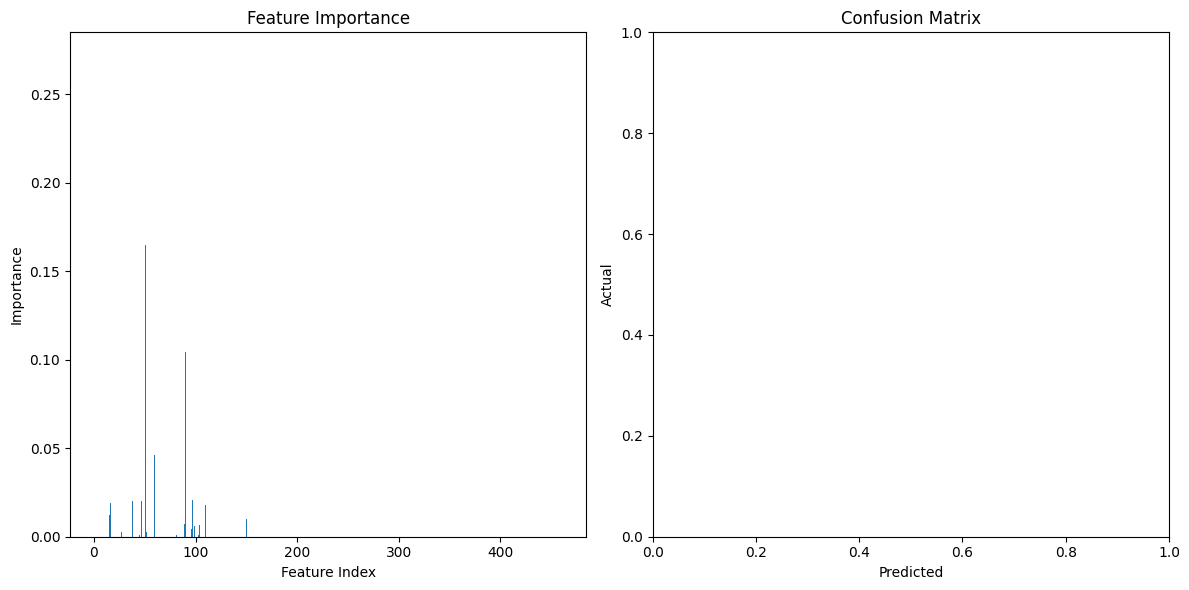

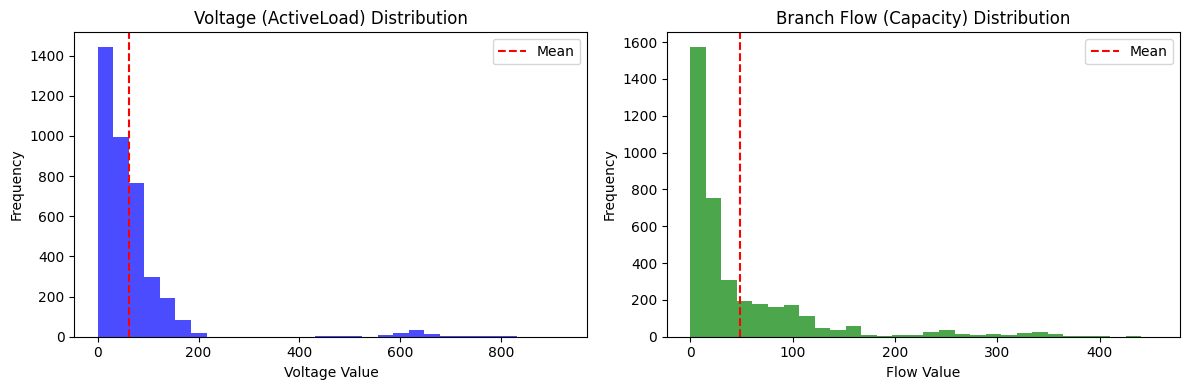


=== SUMMARY ===
Multipersistence analysis completed successfully!
- Used 10 voltage thresholds and 15 flow thresholds
- Generated 462 features per graph
- Achieved 0.9000 accuracy on test set
- Cross-validation accuracy: 0.9700 ± 0.0458


In [9]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

# Plot confusion matrix
plt.subplot(1, 2, 2)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Plot threshold distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(all_voltage_vals, bins=30, alpha=0.7, color='blue')
plt.axvline(np.mean(all_voltage_vals), color='red', linestyle='--', label='Mean')
plt.title('Voltage (ActiveLoad) Distribution')
plt.xlabel('Voltage Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(all_flow_vals, bins=30, alpha=0.7, color='green')
plt.axvline(np.mean(all_flow_vals), color='red', linestyle='--', label='Mean')
plt.title('Branch Flow (Capacity) Distribution')
plt.xlabel('Flow Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== SUMMARY ===")
print(f"Multipersistence analysis completed successfully!")
print(f"- Used {len(thr_voltage)} voltage thresholds and {len(thr_flow)} flow thresholds")
print(f"- Generated {features.shape[1]} features per graph")
print(f"- Achieved {accuracy:.4f} accuracy on test set")
print(f"- Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
